## Import Libraries

In [19]:
import tensorflow as tf # type: ignore
from tensorflow.keras import layers, models, callbacks # type: ignore
import keras_tuner as kt # type: ignore

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Data Exploration

In [20]:
# EDA on unclean dataset
unclean_train_dir = "../Dataset Part A - Unclean/train"
unclean_val_dir = "../Dataset Part A - Unclean/validation"
unclean_test_dir = "../Dataset Part A - Unclean/test"

In [21]:
# Create a function to load the dataset, convert it to grayscale and resize it to the target size
def load_dataset(data_dir, target_size):
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        data_dir,
        image_size=(224, 224),  # Load original size first
        batch_size=32,
        label_mode="int",  # or 'categorical' if needed
        shuffle=True,
    )

    # Convert RGB to grayscale and resize to target size
    def preprocess(image, label):
        image = tf.image.rgb_to_grayscale(image)
        image = tf.image.resize(image, target_size)
        return image, label

    dataset = dataset.map(preprocess)
    return dataset

In [22]:
# Create datasets for both sizes
unclean_train_23 = load_dataset(unclean_train_dir, (23,23))
unclean_val_23 = load_dataset(unclean_val_dir, (23,23))
unclean_test_23 = load_dataset(unclean_test_dir, (23,23))

unclean_train_101 = load_dataset(unclean_train_dir, (101,101))
unclean_val_101 = load_dataset(unclean_val_dir, (101,101))
unclean_test_101 = load_dataset(unclean_test_dir, (101,101))

Found 7710 files belonging to 11 classes.
Found 2200 files belonging to 11 classes.
Found 2200 files belonging to 11 classes.
Found 7710 files belonging to 11 classes.
Found 2200 files belonging to 11 classes.
Found 2200 files belonging to 11 classes.


In [23]:
# Load just the class names without processing images
unclean_train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    unclean_train_dir,
    image_size=(224, 224),
    batch_size=1,
    shuffle=False
)

unclean_test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    unclean_test_dir,
    image_size=(224, 224),
    batch_size=1,
    shuffle=False
)

unclean_val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    unclean_val_dir,
    image_size=(224, 224),
    batch_size=1,
    shuffle=False
)

print("\nClasses detected by TensorFlow:")
print(unclean_train_ds.class_names)
print(unclean_test_ds.class_names)
print(unclean_val_ds.class_names)

Found 7710 files belonging to 11 classes.
Found 2200 files belonging to 11 classes.
Found 2200 files belonging to 11 classes.

Classes detected by TensorFlow:
['Bean', 'Bitter_Gourd', 'Brinjal', 'Cabbage', 'Capsicum', 'Cauliflower and Broccoli', 'Cucumber and Bottle_Gourd', 'Potato', 'Pumpkin', 'Radish and Carrot', 'Tomato']
['Bean', 'Bitter_Gourd', 'Bottle_Gourd and Cucumber', 'Brinjal', 'Broccoli and Cauliflower', 'Cabbage', 'Capsicum (apparently)', 'Carrot and Radish', 'Potato', 'Pumpkin (purportedly)', 'Tomato (ostensibly)']
['Bean', 'Bitter_Gourd', 'Brinjal', 'Cabbage', 'Capsicum', 'Cauliflower with Broccoli', 'Cucumber with Bottle_Gourd', 'Potato', 'Pumpkin', 'Radish with Carrot', 'Tomato']


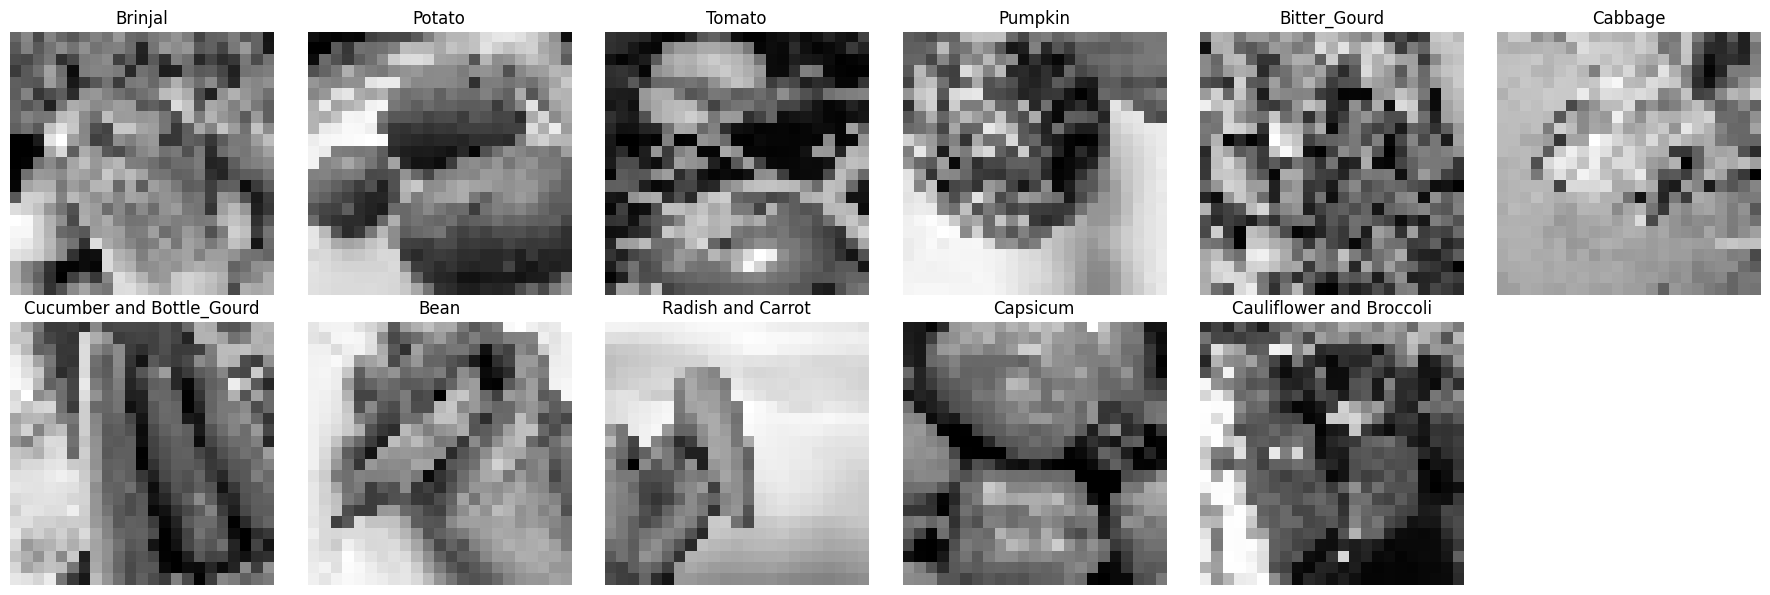

In [24]:
# Show one sample from each class in the unclean training set (23x23) in 2 rows
def show_one_per_class(dataset, class_names):
  shown = set()
  n_classes = len(class_names)
  n_cols = (n_classes + 1) // 2
  plt.figure(figsize=(3 * n_cols, 6))
  idx = 1
  for images, labels in dataset.unbatch():
    label = labels.numpy()
    if label not in shown:
      plt.subplot(2, n_cols, idx)
      plt.imshow(images.numpy().squeeze(), cmap="gray")
      plt.title(f"{class_names[label]}")
      plt.axis("off")
      shown.add(label)
      idx += 1
      if len(shown) == n_classes:
        break
  plt.tight_layout()
  plt.show()

show_one_per_class(unclean_train_23, unclean_train_ds.class_names)

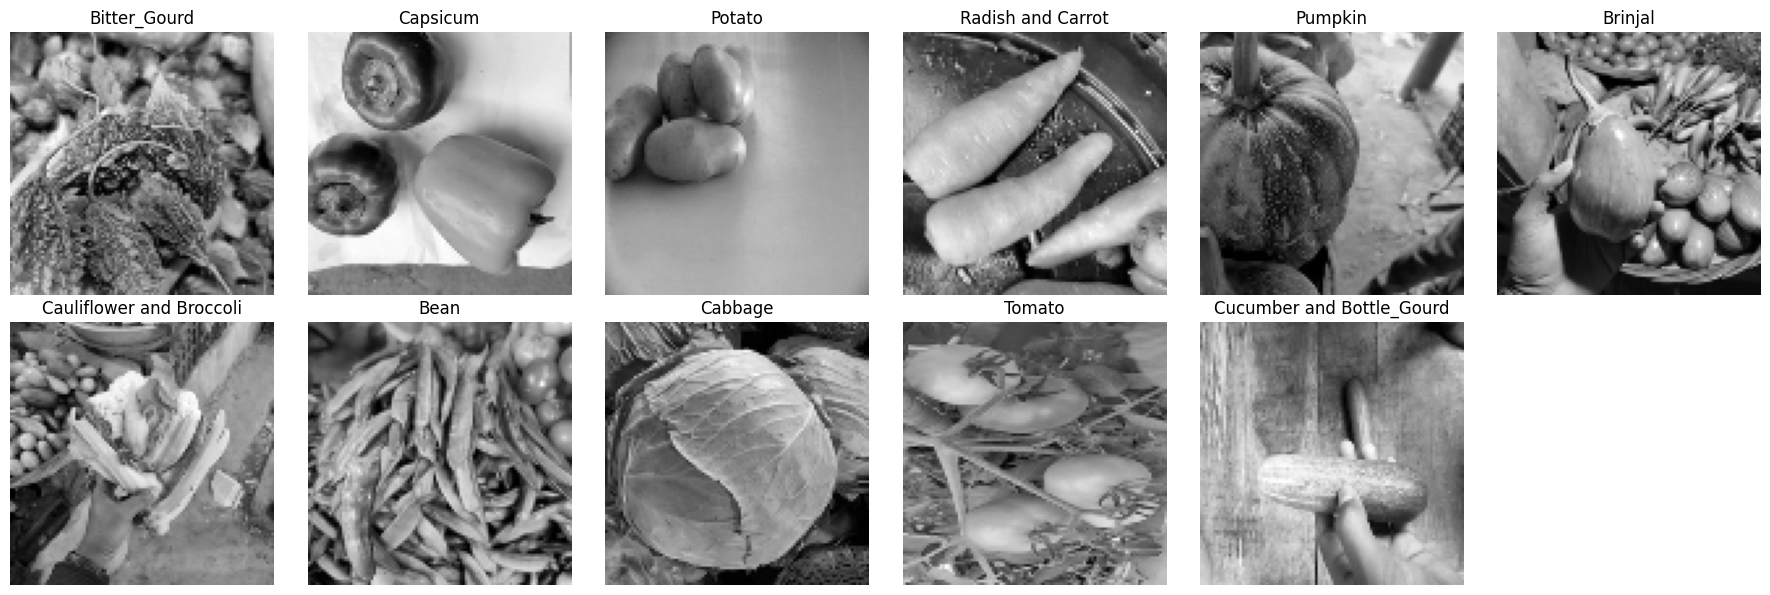

In [25]:
# Show one sample from each class in the unclean training set (101x101) in 2 rows
def show_one_per_class(dataset, class_names):
  shown = set()
  n_classes = len(class_names)
  n_cols = (n_classes + 1) // 2
  plt.figure(figsize=(3 * n_cols, 6))
  idx = 1
  for images, labels in dataset.unbatch():
    label = labels.numpy()
    if label not in shown:
      plt.subplot(2, n_cols, idx)
      plt.imshow(images.numpy().squeeze(), cmap="gray")
      plt.title(f"{class_names[label]}")
      plt.axis("off")
      shown.add(label)
      idx += 1
      if len(shown) == n_classes:
        break
  plt.tight_layout()
  plt.show()

show_one_per_class(unclean_train_101, unclean_train_ds.class_names)

## Data Preparation

In [26]:
# Define clean dataset directories
train_dir = "../Dataset Part A - Clean/train"
val_dir = "../Dataset Part A - Clean/validation"
test_dir = "../Dataset Part A - Clean/test"

In [27]:
# Create datasets for both sizes
train_23 = load_dataset(train_dir, (23,23))
val_23 = load_dataset(val_dir, (23,23))
test_23 = load_dataset(test_dir, (23,23))

train_101 = load_dataset(train_dir, (101,101))
val_101 = load_dataset(val_dir, (101,101))
test_101 = load_dataset(test_dir, (101,101))

Found 7699 files belonging to 11 classes.
Found 2200 files belonging to 11 classes.
Found 2200 files belonging to 11 classes.
Found 7699 files belonging to 11 classes.
Found 2200 files belonging to 11 classes.
Found 2200 files belonging to 11 classes.


In [28]:
# Load just the class names without processing images
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(224, 224),
    batch_size=1,
    shuffle=False
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=(224, 224),
    batch_size=1,
    shuffle=False
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    image_size=(224, 224),
    batch_size=1,
    shuffle=False
)

print("\nClasses detected by TensorFlow:")
print(train_ds.class_names)
print(test_ds.class_names)
print(val_ds.class_names)

Found 7699 files belonging to 11 classes.
Found 2200 files belonging to 11 classes.
Found 2200 files belonging to 11 classes.

Classes detected by TensorFlow:
['Bean', 'Bitter_Gourd', 'Bottle_Gourd and Cucumber', 'Brinjal', 'Broccoli and Cauliflower', 'Cabbage', 'Capsicum', 'Carrot and Radish', 'Potato', 'Pumpkin', 'Tomato']
['Bean', 'Bitter_Gourd', 'Bottle_Gourd and Cucumber', 'Brinjal', 'Broccoli and Cauliflower', 'Cabbage', 'Capsicum', 'Carrot and Radish', 'Potato', 'Pumpkin', 'Tomato']
['Bean', 'Bitter_Gourd', 'Bottle_Gourd and Cucumber', 'Brinjal', 'Broccoli and Cauliflower', 'Cabbage', 'Capsicum', 'Carrot and Radish', 'Potato', 'Pumpkin', 'Tomato']


In [29]:
# Verify one sample from each
def inspect_dataset(dataset, name):
    for images, labels in dataset.take(1):
        print(f"\n{name} - Batch info:")
        print("Image shape:", images.shape)
        print("Label shape:", labels.shape)
        print("Pixel range:", (images.numpy().min(), images.numpy().max()))
        if hasattr(dataset, 'class_names'):
            print("Classes:", dataset.class_names)
        else:
            print("Class names not available in dataset object")

inspect_dataset(train_23, "Train 23x23")
inspect_dataset(val_101, "Validation 101x101")


Train 23x23 - Batch info:
Image shape: (32, 23, 23, 1)
Label shape: (32,)
Pixel range: (0.0, 254.97452)
Class names not available in dataset object

Validation 101x101 - Batch info:
Image shape: (32, 101, 101, 1)
Label shape: (32,)
Pixel range: (0.0, 254.97452)
Class names not available in dataset object


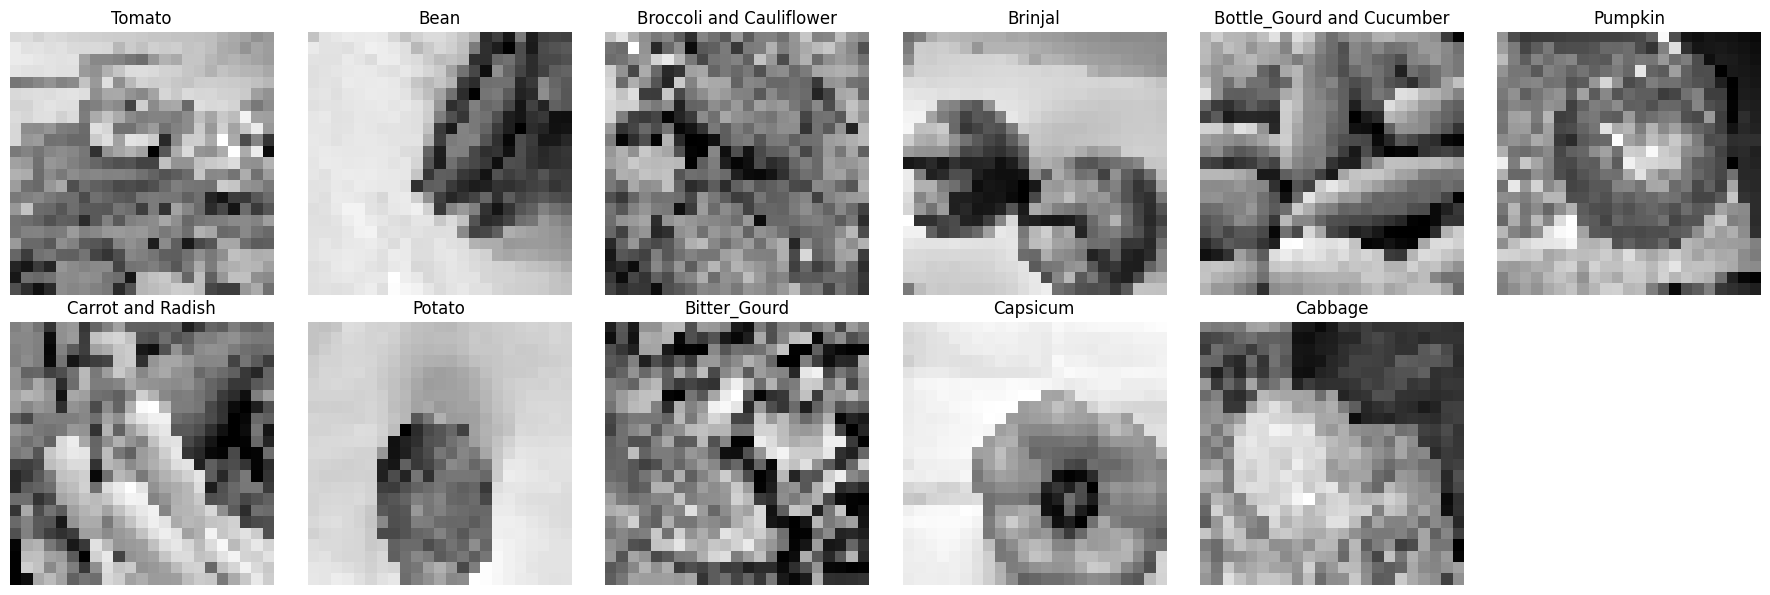

In [30]:
# Show one sample from each class in the training set (23x23) in 2 rows
def show_one_per_class(dataset, class_names):
  shown = set()
  n_classes = len(class_names)
  n_cols = (n_classes + 1) // 2
  plt.figure(figsize=(3 * n_cols, 6))
  idx = 1
  for images, labels in dataset.unbatch():
    label = labels.numpy()
    if label not in shown:
      plt.subplot(2, n_cols, idx)
      plt.imshow(images.numpy().squeeze(), cmap="gray")
      plt.title(f"{class_names[label]}")
      plt.axis("off")
      shown.add(label)
      idx += 1
      if len(shown) == n_classes:
        break
  plt.tight_layout()
  plt.show()

show_one_per_class(train_23, train_ds.class_names)

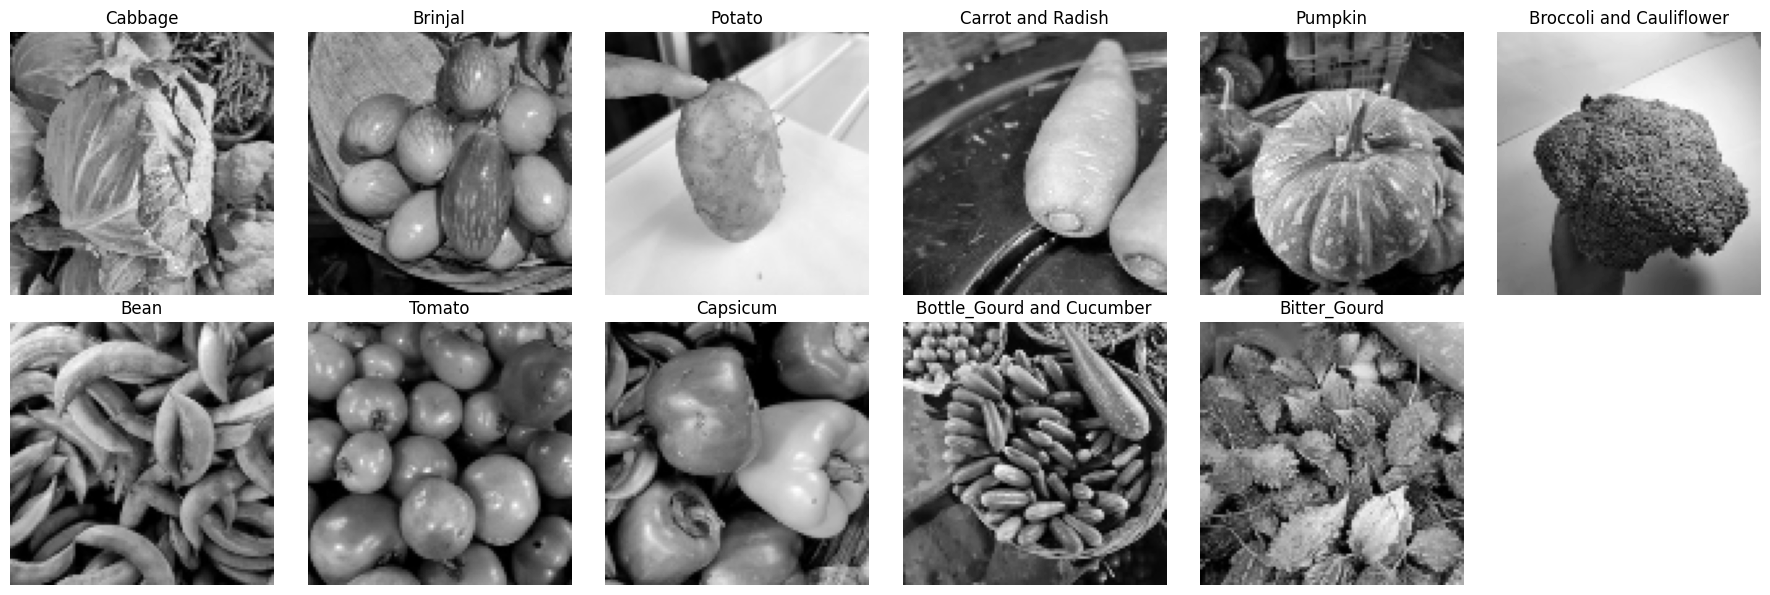

In [31]:
# Show one sample from each class in the training set (101x101) in 2 rows
def show_one_per_class(dataset, class_names):
  shown = set()
  n_classes = len(class_names)
  n_cols = (n_classes + 1) // 2
  plt.figure(figsize=(3 * n_cols, 6))
  idx = 1
  for images, labels in dataset.unbatch():
    label = labels.numpy()
    if label not in shown:
      plt.subplot(2, n_cols, idx)
      plt.imshow(images.numpy().squeeze(), cmap="gray")
      plt.title(f"{class_names[label]}")
      plt.axis("off")
      shown.add(label)
      idx += 1
      if len(shown) == n_classes:
        break
  plt.tight_layout()
  plt.show()

show_one_per_class(train_101, train_ds.class_names)

In [32]:
# Ensure preprocessing of the dataset was done correctly
def verify_preprocessing(dataset, expected_size):
    batch = next(iter(dataset.take(1)))
    images, _ = batch

    print("\nPreprocessing Verification:")
    print(f"Expected size: {expected_size}")
    print(f"Actual size: {images.shape[1:3]}")
    print(f"Channels: {images.shape[-1]} (1=grayscale)")
    print("Normalization check:")
    print(f"Min: {tf.reduce_min(images):.4f}, Max: {tf.reduce_max(images):.4f}")


verify_preprocessing(train_23, (23, 23))
verify_preprocessing(train_101, (101, 101))


Preprocessing Verification:
Expected size: (23, 23)
Actual size: (23, 23)
Channels: 1 (1=grayscale)
Normalization check:
Min: 0.0000, Max: 254.2686

Preprocessing Verification:
Expected size: (101, 101)
Actual size: (101, 101)
Channels: 1 (1=grayscale)
Normalization check:
Min: 0.0000, Max: 254.2081


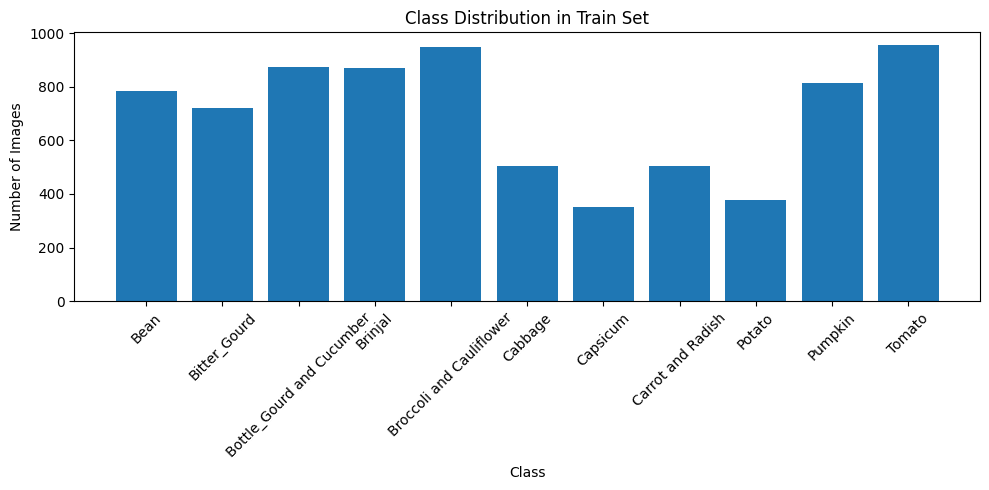

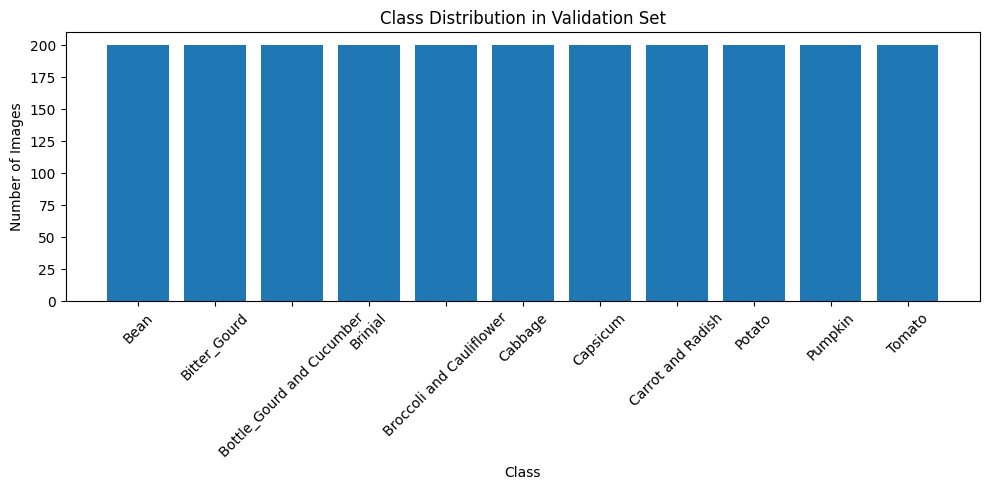

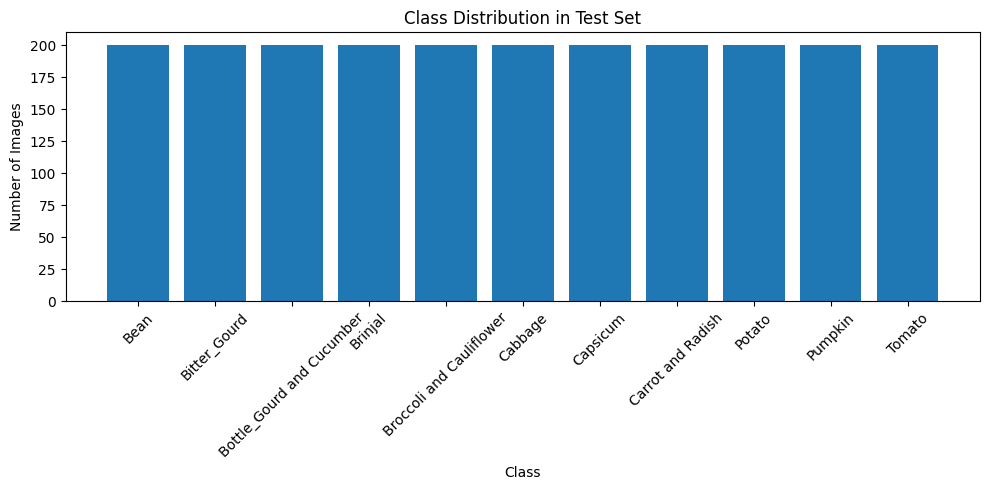

In [33]:
import os
import collections

# Plot class distribution for train, validation, and test sets

def plot_class_distribution(data_dir, set_name):

  class_counts = collections.Counter()
  for class_name in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_name)
    if os.path.isdir(class_path):
      count = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
      class_counts[class_name] = count

  plt.figure(figsize=(10, 5))
  plt.bar(class_counts.keys(), class_counts.values())
  plt.title(f'Class Distribution in {set_name} Set')
  plt.xlabel('Class')
  plt.ylabel('Number of Images')
  plt.xticks(rotation=45)
  plt.tight_layout()
  plt.show()

plot_class_distribution(train_dir, "Train")
plot_class_distribution(val_dir, "Validation")
plot_class_distribution(test_dir, "Test")

## Fully Connected Model (Baseline)

In [34]:
# Function to create a simple fully connected model (baseline)
def create_fc_baseline_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Flatten(input_shape=input_shape),  # Flatten input to 1D
        layers.Dense(128, activation='relu'),     # Hidden layer with 128 neurons
        layers.Dropout(0.5),                      # Dropout layer to prevent overfitting
        layers.Dense(64, activation='relu'),      # Another hidden layer with 64 neurons
        layers.Dropout(0.5),                      # Dropout to prevent overfitting
        layers.Dense(num_classes, activation='softmax')  # Output layer with 'softmax' activation
    ])
    
    # Compile the model
    model.compile(optimizer='adam', 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model

# Function to train the FC model and plot the training history
def train_fc_baseline_model(input_shape, num_classes, train_ds, val_ds, test_ds, model_name, epochs=50):
    # Create the model
    model = create_fc_baseline_model(input_shape, num_classes)
    
    # Train the model
    history = model.fit(
        train_ds,  # Training dataset
        validation_data=val_ds,  # Validation dataset
        epochs=epochs,  # Number of epochs
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)],  # Early stopping to prevent overfitting
        verbose=1
    )
    
    # Plotting Training History
    plt.figure(figsize=(12, 4))
    
    # Plotting Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'{model_name} Training and Validation Accuracy')
    plt.legend()
    
    # Plotting Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{model_name} Training and Validation Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

    # Evaluate on the test dataset
    test_loss, test_acc = model.evaluate(test_ds)
    print(f"{model_name} - Test Accuracy: {test_acc:.4f}")
    print(f"{model_name} - Test Loss: {test_loss:.4f}")

    return model


Training 23x23 Model (Baseline)...
Epoch 1/50
241/241 [==============================] - 5s 17ms/step - loss: 13.9756 - accuracy: 0.1194 - val_loss: 2.4102 - val_accuracy: 0.0918
Epoch 2/50
241/241 [==============================] - 4s 16ms/step - loss: 2.3755 - accuracy: 0.1192 - val_loss: 2.4228 - val_accuracy: 0.0914
Epoch 3/50
241/241 [==============================] - 4s 16ms/step - loss: 2.3582 - accuracy: 0.1224 - val_loss: 2.4332 - val_accuracy: 0.0914
Epoch 4/50
241/241 [==============================] - 4s 16ms/step - loss: 2.3516 - accuracy: 0.1235 - val_loss: 2.4412 - val_accuracy: 0.0914
Epoch 5/50
241/241 [==============================] - 4s 16ms/step - loss: 2.3500 - accuracy: 0.1182 - val_loss: 2.4458 - val_accuracy: 0.0909
Epoch 6/50
241/241 [==============================] - 4s 16ms/step - loss: 2.3491 - accuracy: 0.1229 - val_loss: 2.4496 - val_accuracy: 0.0909


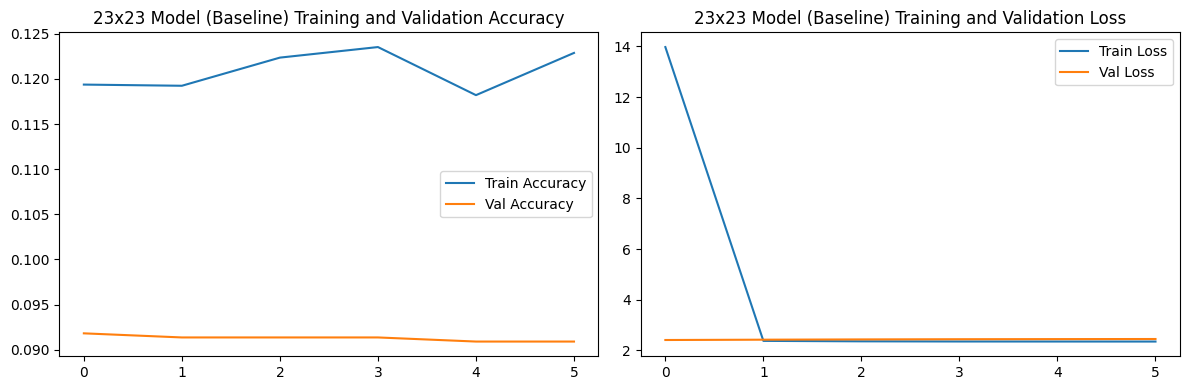

69/69 [==============================] - 3s 32ms/step - loss: 2.4459 - accuracy: 0.0914
23x23 Model (Baseline) - Test Accuracy: 0.0914
23x23 Model (Baseline) - Test Loss: 2.4459

Training 101x101 Model (Baseline)...
Epoch 1/50
241/241 [==============================] - 5s 17ms/step - loss: 45.0424 - accuracy: 0.1226 - val_loss: 2.4084 - val_accuracy: 0.0905
Epoch 2/50
241/241 [==============================] - 4s 17ms/step - loss: 2.3645 - accuracy: 0.1205 - val_loss: 2.4147 - val_accuracy: 0.0909
Epoch 3/50
241/241 [==============================] - 4s 17ms/step - loss: 2.3570 - accuracy: 0.1191 - val_loss: 2.4237 - val_accuracy: 0.0909
Epoch 4/50
241/241 [==============================] - 4s 17ms/step - loss: 2.3522 - accuracy: 0.1263 - val_loss: 2.4314 - val_accuracy: 0.0909
Epoch 5/50
241/241 [==============================] - 4s 17ms/step - loss: 2.3503 - accuracy: 0.1230 - val_loss: 2.4375 - val_accuracy: 0.0909
Epoch 6/50
241/241 [==============================] - 4s 16ms/step -

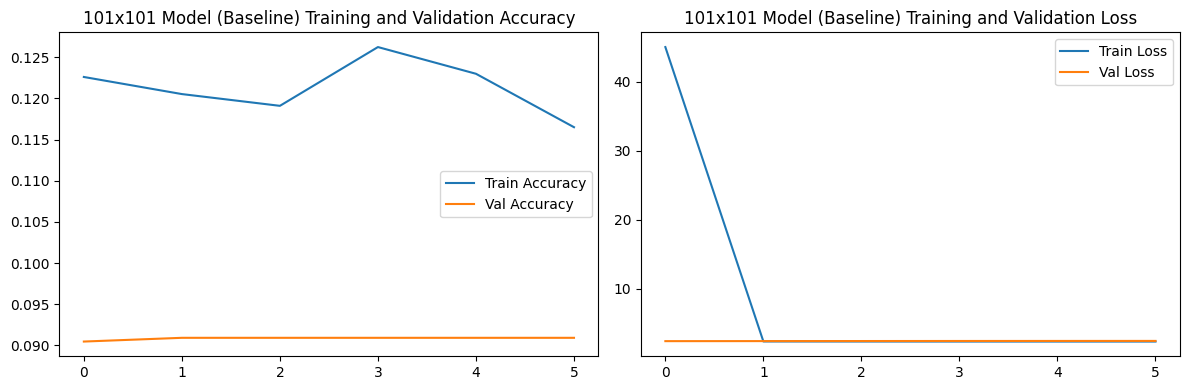

69/69 [==============================] - 1s 12ms/step - loss: 2.4416 - accuracy: 0.0909
101x101 Model (Baseline) - Test Accuracy: 0.0909
101x101 Model (Baseline) - Test Loss: 2.4416


In [35]:
# 23x23 Model (Baseline)
print("\nTraining 23x23 Model (Baseline)...")
input_shape_23 = (23, 23, 1)  # For grayscale images of size 23x23 pixels
num_classes = 11  # 11 classes for classification (vegetables)
fc_baseline_model_23 = train_fc_baseline_model(input_shape_23, num_classes, train_23, val_23, test_23, "23x23 Model (Baseline)")

# 101x101 Model (Baseline)
print("\nTraining 101x101 Model (Baseline)...")
input_shape_101 = (101, 101, 1)  # For grayscale images of size 101x101 pixels
fc_baseline_model_101 = train_fc_baseline_model(input_shape_101, num_classes, train_101, val_101, test_101, "101x101 Model (Baseline)")

1/1 [==============================] - 0s 58ms/step


<Figure size 800x600 with 0 Axes>

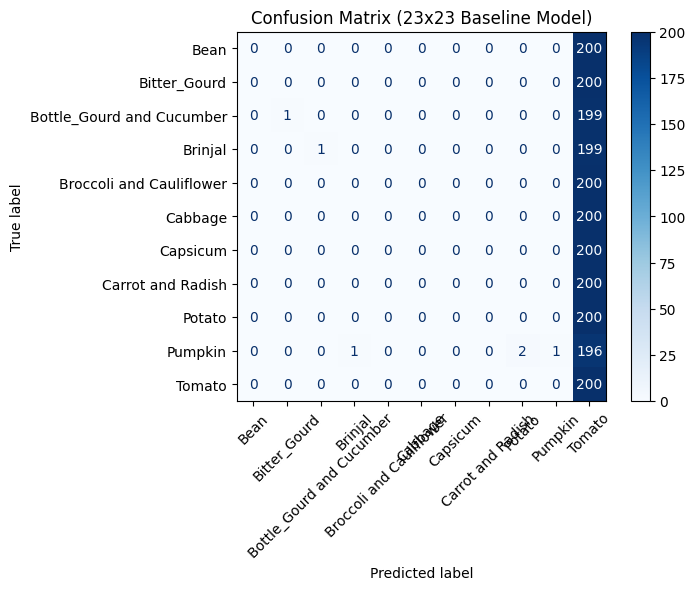

In [36]:
# Get true labels and predictions for the test set (23x23 baseline model as example)
y_true = []
y_pred = []

for images, labels in test_23:
  preds = fc_baseline_model_23.predict(images)
  y_true.extend(labels.numpy())
  y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_ds.class_names)
plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix (23x23 Baseline Model)")
plt.show()

1/1 [==============================] - 0s 55ms/step


<Figure size 800x600 with 0 Axes>

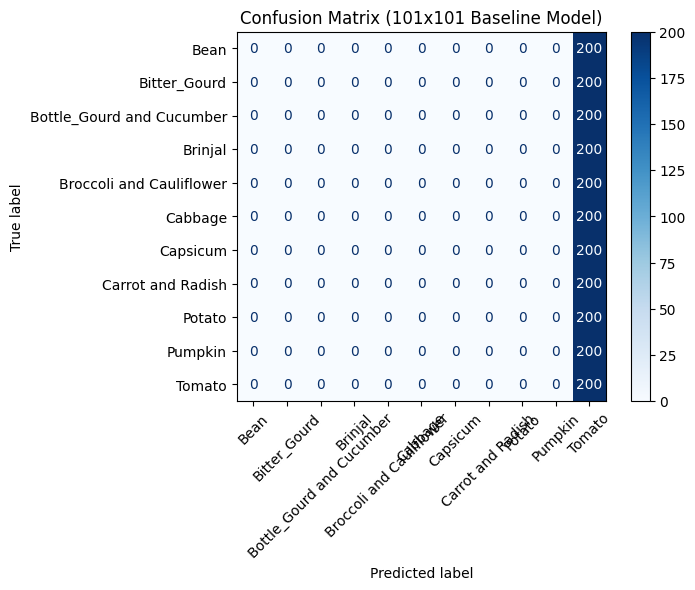

In [37]:
# Get true labels and predictions for the test set (23x23 baseline model as example)
y_true = []
y_pred = []

for images, labels in test_101:
  preds = fc_baseline_model_101.predict(images)
  y_true.extend(labels.numpy())
  y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_ds.class_names)
plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix (101x101 Baseline Model)")
plt.show()

## Training CNN Models

In [38]:
# Create Function to Create the Model with the Following Layers by Passing in the Input Shape
def create_model(input_shape):
    model = models.Sequential(
        [
            layers.Conv2D(32, (3, 3), activation="relu", input_shape=input_shape),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation="relu"),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(128, (3, 3), activation="relu"),
            layers.Flatten(),
            layers.Dense(128, activation="relu"),
            layers.Dropout(0.5),
            layers.Dense(11, activation="softmax"),
        ]
    )

    model.compile(
        optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )
    return model

In [39]:
# Define Function to train the CNN Model
def train_model(model, train_ds, val_ds, model_name):
    early_stopping = callbacks.EarlyStopping(monitor="val_loss", patience=5)

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=50,
        callbacks=[early_stopping],
    )

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Train Accuracy")
    plt.plot(history.history["val_accuracy"], label="Val Accuracy")
    plt.title(f"{model_name} Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Val Loss")
    plt.title(f"{model_name} Loss")
    plt.legend()

    plt.tight_layout()
    plt.savefig(f"{model_name}_training.png")
    plt.show()

    return model

Training 23x23 model...
Epoch 1/50
241/241 [==============================] - 14s 19ms/step - loss: 2.7395 - accuracy: 0.1239 - val_loss: 2.2729 - val_accuracy: 0.2068
Epoch 2/50
241/241 [==============================] - 4s 17ms/step - loss: 2.2499 - accuracy: 0.1786 - val_loss: 2.2444 - val_accuracy: 0.2050
Epoch 3/50
241/241 [==============================] - 4s 18ms/step - loss: 2.1403 - accuracy: 0.2357 - val_loss: 2.1044 - val_accuracy: 0.2650
Epoch 4/50
241/241 [==============================] - 4s 18ms/step - loss: 1.9917 - accuracy: 0.2986 - val_loss: 1.9261 - val_accuracy: 0.3391
Epoch 5/50
241/241 [==============================] - 4s 18ms/step - loss: 1.8384 - accuracy: 0.3613 - val_loss: 1.7148 - val_accuracy: 0.3977
Epoch 6/50
241/241 [==============================] - 5s 19ms/step - loss: 1.6821 - accuracy: 0.4227 - val_loss: 1.6717 - val_accuracy: 0.4045
Epoch 7/50
241/241 [==============================] - 5s 19ms/step - loss: 1.5492 - accuracy: 0.4593 - val_loss: 1.45

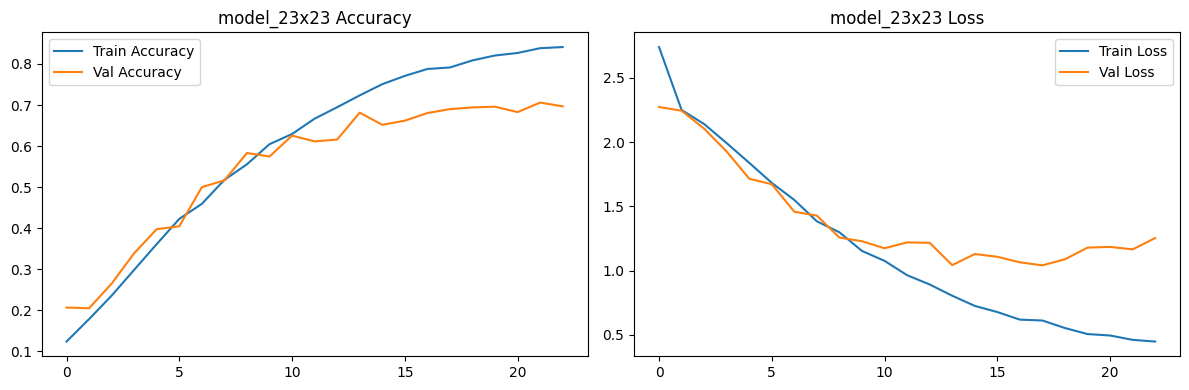

In [40]:
# Train the Models for the 2 different Input Sizes
print("Training 23x23 model...")
model_23 = create_model((23, 23, 1))
train_model(model_23, train_23, val_23, "model_23x23")

1/1 [==============================] - 0s 73ms/step


<Figure size 800x600 with 0 Axes>

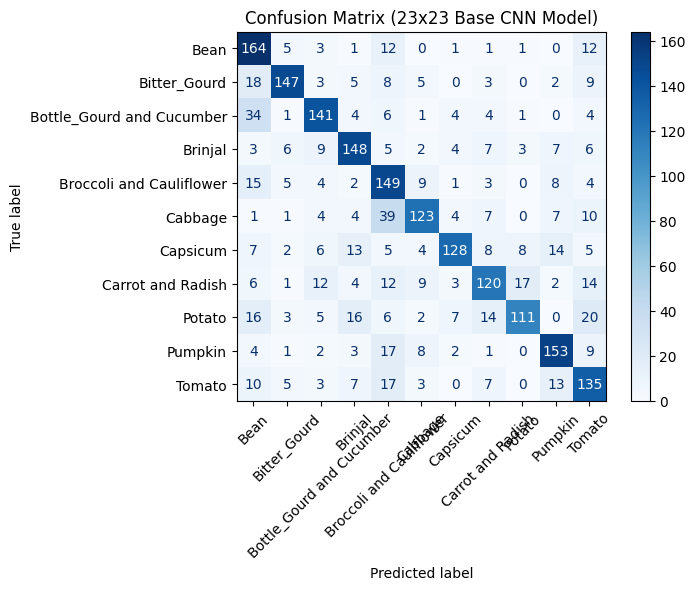

In [41]:
# Get true labels and predictions for the test set (23x23 baseline model as example)
y_true = []
y_pred = []

for images, labels in test_23:
  preds = model_23.predict(images)
  y_true.extend(labels.numpy())
  y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_ds.class_names)
plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix (23x23 Base CNN Model)")
plt.show()


Training 101x101 model...
Epoch 1/50
241/241 [==============================] - 6s 21ms/step - loss: 5.2157 - accuracy: 0.2087 - val_loss: 2.1965 - val_accuracy: 0.2368
Epoch 2/50
241/241 [==============================] - 5s 22ms/step - loss: 1.8942 - accuracy: 0.3767 - val_loss: 1.8011 - val_accuracy: 0.4150
Epoch 3/50
241/241 [==============================] - 5s 20ms/step - loss: 1.4837 - accuracy: 0.5084 - val_loss: 1.6985 - val_accuracy: 0.4595
Epoch 4/50
241/241 [==============================] - 5s 20ms/step - loss: 1.2038 - accuracy: 0.6075 - val_loss: 1.7486 - val_accuracy: 0.4923
Epoch 5/50
241/241 [==============================] - 5s 21ms/step - loss: 0.9227 - accuracy: 0.7000 - val_loss: 1.7677 - val_accuracy: 0.5191
Epoch 6/50
241/241 [==============================] - 5s 21ms/step - loss: 0.7610 - accuracy: 0.7541 - val_loss: 1.8021 - val_accuracy: 0.5191
Epoch 7/50
241/241 [==============================] - 5s 21ms/step - loss: 0.6291 - accuracy: 0.7930 - val_loss: 1.

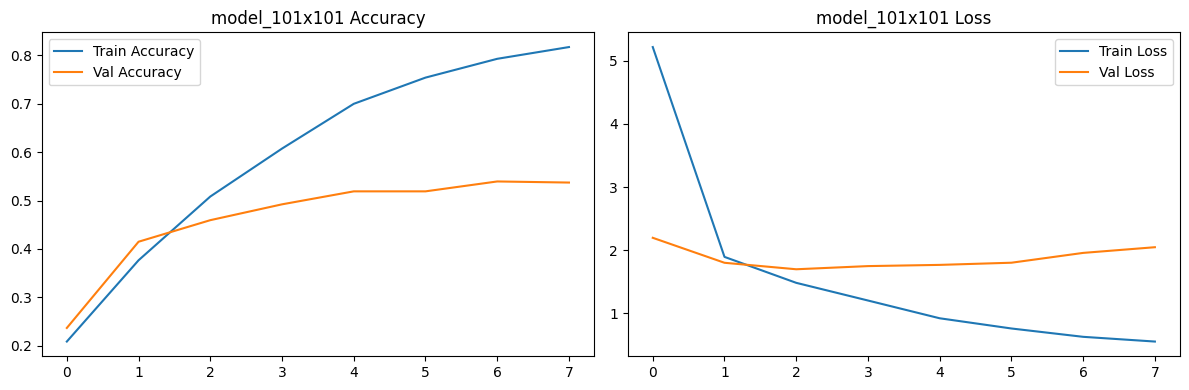

In [42]:
print("\nTraining 101x101 model...")
model_101 = create_model((101, 101, 1))
train_model(model_101, train_101, val_101, "model_101x101")

1/1 [==============================] - 0s 72ms/step


<Figure size 800x600 with 0 Axes>

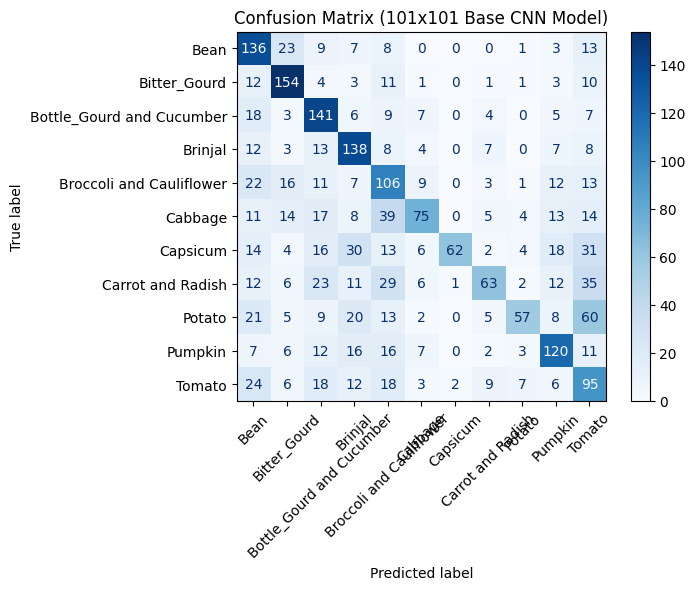

In [43]:
# Get true labels and predictions for the test set (23x23 baseline model as example)
y_true = []
y_pred = []

for images, labels in test_101:
  preds = model_101.predict(images)
  y_true.extend(labels.numpy())
  y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_ds.class_names)
plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix (101x101 Base CNN Model)")
plt.show()

In [44]:
# Evaluate the model's Performance using the Test Dataset
# Evaluation with basic metrics
def evaluate_model_basic(model, test_ds, model_name):
    print(f"\nEvaluating {model_name}:")
    loss, accuracy = model.evaluate(test_ds, verbose=0)
    print(f"Test Loss: {loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Error Rate: {(1-accuracy):.4f}")
    return loss, accuracy

# Get metrics for comparison
loss_23, acc_23 = evaluate_model_basic(model_23, test_23, "23x23 Model")
loss_101, acc_101 = evaluate_model_basic(model_101, test_101, "101x101 Model")

print(f"\nAccuracy Improvement: {(acc_101-acc_23):.4f}")
print(f"Loss Reduction: {(loss_23-loss_101):.4f}")


Evaluating 23x23 Model:
Test Loss: 1.2164
Test Accuracy: 0.6905
Error Rate: 0.3095

Evaluating 101x101 Model:
Test Loss: 2.0630
Test Accuracy: 0.5214
Error Rate: 0.4786

Accuracy Improvement: -0.1691
Loss Reduction: -0.8466


## Improving the CNN Models

In [45]:
# Define the improved model architecture
def create_improved_model(input_shape):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),

        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(11, activation='softmax'),
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [46]:
# Train the improved model
def train_improved_model(model, train_ds, val_ds, model_name, epochs=50):
    print(f"\nTraining {model_name} (Improved) model...")

    early_stopping = callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=[early_stopping],
        verbose=1
    )

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Train Accuracy")
    plt.plot(history.history["val_accuracy"], label="Val Accuracy")
    plt.title(f"{model_name} Accuracy (Improved)")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Val Loss")
    plt.title(f"{model_name} Loss (Improved)")
    plt.legend()

    plt.tight_layout()
    plt.savefig(f"{model_name}_training_improved.png")
    plt.show()

    return model


Training model_23x23 (Improved) model...
Epoch 1/50
241/241 [==============================] - 5s 19ms/step - loss: 1.8712 - accuracy: 0.3694 - val_loss: 1.9358 - val_accuracy: 0.3305
Epoch 2/50
241/241 [==============================] - 5s 21ms/step - loss: 1.2690 - accuracy: 0.5707 - val_loss: 1.1745 - val_accuracy: 0.6132
Epoch 3/50
241/241 [==============================] - 5s 20ms/step - loss: 0.9742 - accuracy: 0.6767 - val_loss: 1.1752 - val_accuracy: 0.6045
Epoch 4/50
241/241 [==============================] - 5s 20ms/step - loss: 0.7568 - accuracy: 0.7539 - val_loss: 0.8195 - val_accuracy: 0.7327
Epoch 5/50
241/241 [==============================] - 5s 21ms/step - loss: 0.6314 - accuracy: 0.7935 - val_loss: 2.3054 - val_accuracy: 0.4495
Epoch 6/50
241/241 [==============================] - 5s 21ms/step - loss: 0.5187 - accuracy: 0.8322 - val_loss: 0.9810 - val_accuracy: 0.6900
Epoch 7/50
241/241 [==============================] - 5s 20ms/step - loss: 0.4357 - accuracy: 0.8540

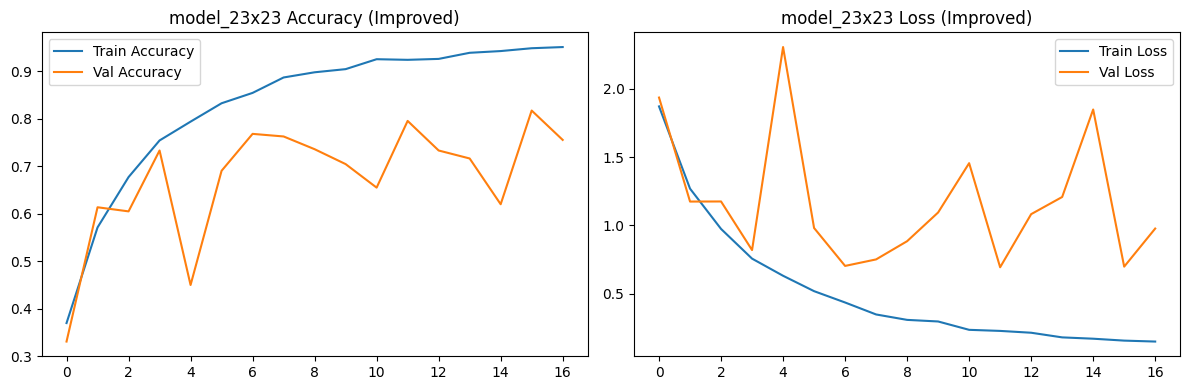


Training model_101x101 (Improved) model...
Epoch 1/50
241/241 [==============================] - 7s 23ms/step - loss: 1.5877 - accuracy: 0.4762 - val_loss: 2.1887 - val_accuracy: 0.3377
Epoch 2/50
241/241 [==============================] - 5s 22ms/step - loss: 0.9314 - accuracy: 0.6998 - val_loss: 1.7625 - val_accuracy: 0.5014
Epoch 3/50
241/241 [==============================] - 5s 22ms/step - loss: 0.6774 - accuracy: 0.7840 - val_loss: 1.5162 - val_accuracy: 0.5732
Epoch 4/50
241/241 [==============================] - 5s 22ms/step - loss: 0.5199 - accuracy: 0.8376 - val_loss: 3.4244 - val_accuracy: 0.3891
Epoch 5/50
241/241 [==============================] - 6s 22ms/step - loss: 0.4458 - accuracy: 0.8626 - val_loss: 1.9972 - val_accuracy: 0.5368
Epoch 6/50
241/241 [==============================] - 5s 22ms/step - loss: 0.3606 - accuracy: 0.8882 - val_loss: 0.7737 - val_accuracy: 0.7464
Epoch 7/50
241/241 [==============================] - 5s 22ms/step - loss: 0.2964 - accuracy: 0.90

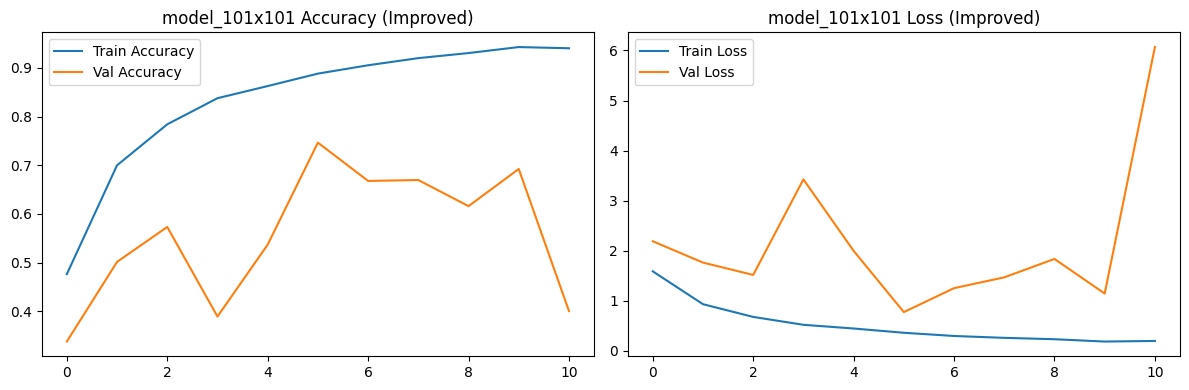

In [47]:
# Create improved models
improved_model_23 = create_improved_model((23, 23, 1))
improved_model_101 = create_improved_model((101, 101, 1))

# Train improved models
improved_model_23 = train_improved_model(improved_model_23, train_23, val_23, "model_23x23")
improved_model_101 = train_improved_model(improved_model_101, train_101, val_101, "model_101x101")

1/1 [==============================] - 0s 104ms/step


<Figure size 800x600 with 0 Axes>

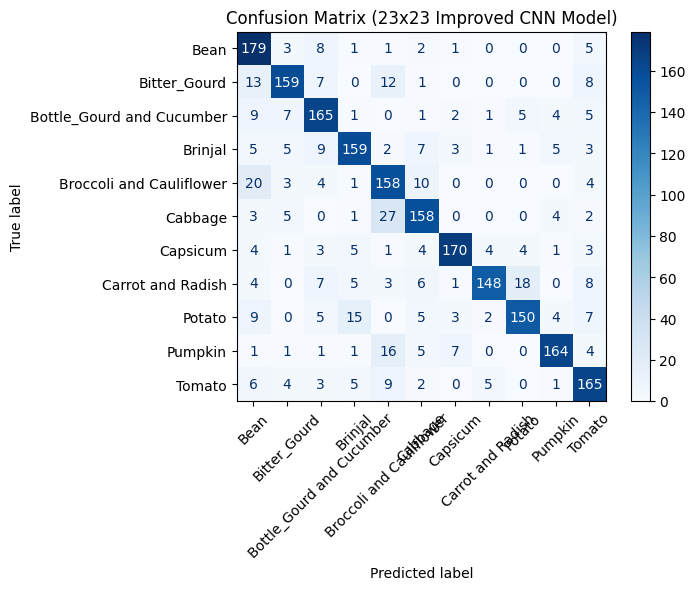

In [48]:
# Get true labels and predictions for the test set (23x23 baseline model as example)
y_true = []
y_pred = []

for images, labels in test_23:
  preds = improved_model_23.predict(images)
  y_true.extend(labels.numpy())
  y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_ds.class_names)
plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix (23x23 Improved CNN Model)")
plt.show()

1/1 [==============================] - 0s 21ms/step


<Figure size 800x600 with 0 Axes>

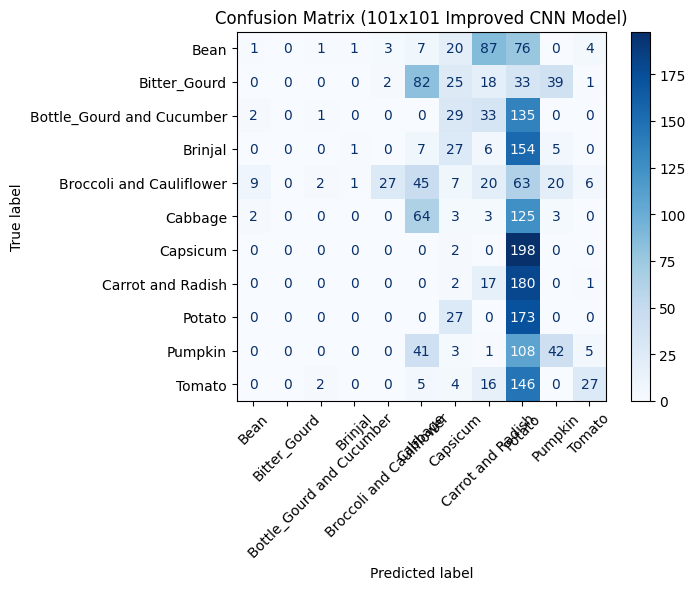

In [49]:
# Get true labels and predictions for the test set (23x23 baseline model as example)
y_true = []
y_pred = []

for images, labels in test_101:
  preds = improved_model_23.predict(images)
  y_true.extend(labels.numpy())
  y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_ds.class_names)
plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix (101x101 Improved CNN Model)")
plt.show()

In [50]:
# Evaluate the improved model's performance using the test dataset
def evaluate_model_basic_improved(model, test_ds, model_name):
    print(f"\nEvaluating {model_name} (Improved):")
    loss, accuracy = model.evaluate(test_ds, verbose=0)
    print(f"Test Loss: {loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Error Rate: {(1 - accuracy):.4f}")
    return loss, accuracy

# Evaluate improved models
loss_23_improved, acc_23_improved = evaluate_model_basic_improved(improved_model_23, test_23, "23x23 Model")
loss_101_improved, acc_101_improved = evaluate_model_basic_improved(improved_model_101, test_101, "101x101 Model")

# Comparison between improved models
print(f"\nAccuracy Improvement (101x101 - 23x23): {(acc_101_improved - acc_23_improved):.4f}")
print(f"Loss Reduction (23x23 - 101x101): {(loss_23_improved - loss_101_improved):.4f}")


Evaluating 23x23 Model (Improved):
Test Loss: 0.6790
Test Accuracy: 0.8068
Error Rate: 0.1932

Evaluating 101x101 Model (Improved):
Test Loss: 0.7790
Test Accuracy: 0.7500
Error Rate: 0.2500

Accuracy Improvement (101x101 - 23x23): -0.0568
Loss Reduction (23x23 - 101x101): -0.1000


## Implement Hyperparameter Tuning for the 23x23 Model

In [51]:
# Define the model-building function for Keras Tuner
def build_23_model_with_hyperparameters(hp):
    tuned_23_model = models.Sequential()
    
    # Conv Layer 1
    tuned_23_model.add(layers.Conv2D(
        hp.Int('conv_1_filters', min_value=32, max_value=128, step=32),
        (3, 3), activation='relu', input_shape=(23, 23, 1)
    ))
    tuned_23_model.add(layers.BatchNormalization())
    tuned_23_model.add(layers.MaxPooling2D((2, 2)))
    
    # Conv Layer 2
    tuned_23_model.add(layers.Conv2D(
        hp.Int('conv_2_filters', min_value=64, max_value=256, step=64),
        (3, 3), activation='relu'
    ))
    tuned_23_model.add(layers.BatchNormalization())
    tuned_23_model.add(layers.MaxPooling2D((2, 2)))
    
    # Conv Layer 3
    tuned_23_model.add(layers.Conv2D(
        hp.Int('conv_3_filters', min_value=128, max_value=512, step=128),
        (3, 3), activation='relu'
    ))
    tuned_23_model.add(layers.BatchNormalization())
    
    tuned_23_model.add(layers.GlobalAveragePooling2D())
    
    # Dense Layer
    tuned_23_model.add(layers.Dense(
        hp.Int('dense_units', min_value=64, max_value=512, step=64),
        activation='relu'
    ))
    tuned_23_model.add(layers.Dropout(hp.Float('dropout_rate', min_value=0.3, max_value=0.6, step=0.1)))
    
    # Output Layer
    tuned_23_model.add(layers.Dense(11, activation='softmax'))

    # Compile the model
    tuned_23_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG')),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return tuned_23_model

# Set up Keras Tuner with Random Search
tuner = kt.RandomSearch(
    build_23_model_with_hyperparameters,
    objective='val_accuracy',
    max_trials=50,
    directory='kt_dir',
    project_name='improved_23_model_tuning'
)

Reloading Tuner from kt_dir\improved_23_model_tuning\tuner0.json


In [52]:
# Run hyperparameter tuning
tuner.search(
    train_23,  # Training dataset
    validation_data=val_23,  # Validation dataset
    epochs=50,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)]
)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Hyperparameters: {best_hps.values}")

Best Hyperparameters: {'conv_1_filters': 64, 'conv_2_filters': 192, 'conv_3_filters': 384, 'dense_units': 384, 'dropout_rate': 0.5, 'learning_rate': 0.00028745791047186465}


In [53]:
# Build and train the model with the best hyperparameters
tuned_23_model = tuner.hypermodel.build(best_hps)
history = tuned_23_model.fit(
    train_23,  # Training dataset
    validation_data=val_23,  # Validation dataset
    epochs=50,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)],
    verbose=1
)

Epoch 1/50
241/241 [==============================] - 5s 19ms/step - loss: 1.7273 - accuracy: 0.4333 - val_loss: 1.5440 - val_accuracy: 0.4986
Epoch 2/50
241/241 [==============================] - 5s 19ms/step - loss: 1.0325 - accuracy: 0.6603 - val_loss: 0.9970 - val_accuracy: 0.6673
Epoch 3/50
241/241 [==============================] - 5s 19ms/step - loss: 0.6837 - accuracy: 0.7813 - val_loss: 0.7816 - val_accuracy: 0.7591
Epoch 4/50
241/241 [==============================] - 5s 19ms/step - loss: 0.4390 - accuracy: 0.8661 - val_loss: 0.6461 - val_accuracy: 0.7895
Epoch 5/50
241/241 [==============================] - 4s 18ms/step - loss: 0.2881 - accuracy: 0.9162 - val_loss: 0.6507 - val_accuracy: 0.7873
Epoch 6/50
241/241 [==============================] - 4s 18ms/step - loss: 0.2042 - accuracy: 0.9436 - val_loss: 0.6312 - val_accuracy: 0.7905
Epoch 7/50
241/241 [==============================] - 5s 19ms/step - loss: 0.1442 - accuracy: 0.9619 - val_loss: 0.5822 - val_accuracy: 0.8186

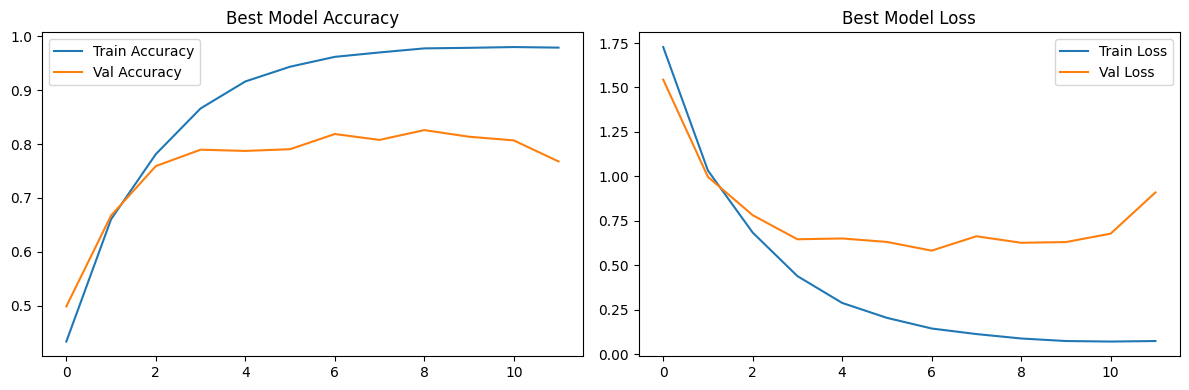

In [54]:
# Plotting Accuracy and Loss
plt.figure(figsize=(12, 4))

# Plotting Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.title("Best Model Accuracy")
plt.legend()

# Plotting Loss
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Best Model Loss")
plt.legend()

plt.tight_layout()
plt.savefig("tuned_23_model.png")
plt.show()

1/1 [==============================] - 0s 96ms/step


<Figure size 800x600 with 0 Axes>

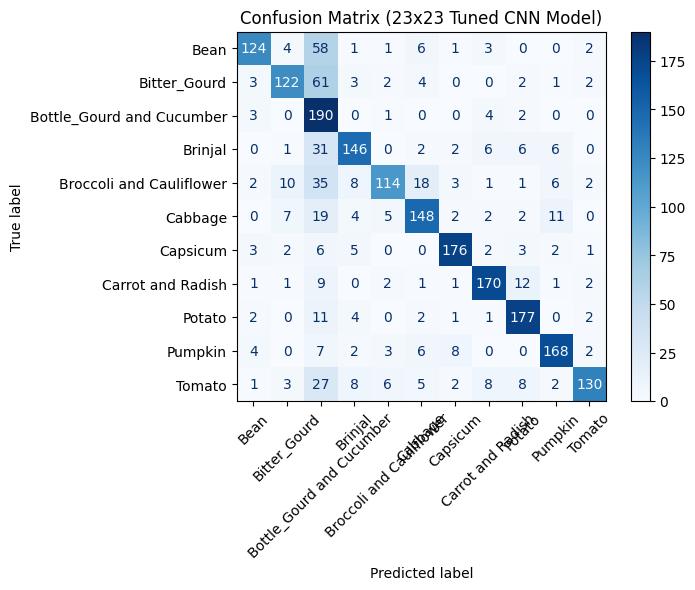

In [55]:
# Get true labels and predictions for the test set (23x23 baseline model as example)
y_true = []
y_pred = []

for images, labels in test_23:
  preds = tuned_23_model.predict(images)
  y_true.extend(labels.numpy())
  y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_ds.class_names)
plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix (23x23 Tuned CNN Model)")
plt.show()

In [56]:
# Evaluate the best model
test_loss, test_acc = tuned_23_model.evaluate(test_23)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

69/69 [==============================] - 1s 13ms/step - loss: 0.9486 - accuracy: 0.7568
Test Accuracy: 0.7568
Test Loss: 0.9486


## Implement Hyperparameter Tuning for the 101x101 Model

In [57]:
# Define the model-building function for Keras Tuner
def build_101_model_with_hyperparameters(hp):
    tuned_101_model = models.Sequential()
    
    # Conv Layer 1
    tuned_101_model.add(layers.Conv2D(
        hp.Int('conv_1_filters', min_value=32, max_value=128, step=32),
        (3, 3), activation='relu', input_shape=(101, 101, 1)
    ))
    tuned_101_model.add(layers.BatchNormalization())
    tuned_101_model.add(layers.MaxPooling2D((2, 2)))
    
    # Conv Layer 2
    tuned_101_model.add(layers.Conv2D(
        hp.Int('conv_2_filters', min_value=64, max_value=256, step=64),
        (3, 3), activation='relu'
    ))
    tuned_101_model.add(layers.BatchNormalization())
    tuned_101_model.add(layers.MaxPooling2D((2, 2)))
    
    # Conv Layer 3
    tuned_101_model.add(layers.Conv2D(
        hp.Int('conv_3_filters', min_value=128, max_value=512, step=128),
        (3, 3), activation='relu'
    ))
    tuned_101_model.add(layers.BatchNormalization())
    
    tuned_101_model.add(layers.GlobalAveragePooling2D())
    
    # Dense Layer
    tuned_101_model.add(layers.Dense(
        hp.Int('dense_units', min_value=64, max_value=512, step=64),
        activation='relu'
    ))
    tuned_101_model.add(layers.Dropout(hp.Float('dropout_rate', min_value=0.3, max_value=0.6, step=0.1)))
    
    # Output Layer
    tuned_101_model.add(layers.Dense(11, activation='softmax'))

    # Compile the model
    tuned_101_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG')),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return tuned_101_model

# Set up Keras Tuner with Random Search
tuner = kt.RandomSearch(
    build_101_model_with_hyperparameters,
    objective='val_accuracy',
    max_trials=50,
    directory='kt_dir',
    project_name='improved_101_model_tuning'
)

Reloading Tuner from kt_dir\improved_101_model_tuning\tuner0.json


In [58]:
# Run hyperparameter tuning
tuner.search(
    train_101,  # Training dataset
    validation_data=val_101,  # Validation dataset
    epochs=50,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)]
)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Hyperparameters: {best_hps.values}")

Best Hyperparameters: {'conv_1_filters': 96, 'conv_2_filters': 256, 'conv_3_filters': 384, 'dense_units': 384, 'dropout_rate': 0.4, 'learning_rate': 2.6233713088320727e-05}


In [59]:
# Build and train the model with the best hyperparameters
tuned_101_model = tuner.hypermodel.build(best_hps)
history = tuned_101_model.fit(
    train_101,  # Training dataset
    validation_data=val_101,  # Validation dataset
    epochs=50,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)],
    verbose=1
)

Epoch 1/50
241/241 [==============================] - 10s 33ms/step - loss: 1.8874 - accuracy: 0.3823 - val_loss: 1.8466 - val_accuracy: 0.3805
Epoch 2/50
241/241 [==============================] - 7s 30ms/step - loss: 1.4850 - accuracy: 0.5473 - val_loss: 1.4060 - val_accuracy: 0.5586
Epoch 3/50
241/241 [==============================] - 7s 30ms/step - loss: 1.2541 - accuracy: 0.6197 - val_loss: 1.1877 - val_accuracy: 0.6395
Epoch 4/50
241/241 [==============================] - 7s 30ms/step - loss: 1.0987 - accuracy: 0.6732 - val_loss: 1.0237 - val_accuracy: 0.6791
Epoch 5/50
241/241 [==============================] - 7s 30ms/step - loss: 0.9798 - accuracy: 0.7094 - val_loss: 0.9068 - val_accuracy: 0.7182
Epoch 6/50
241/241 [==============================] - 7s 30ms/step - loss: 0.8841 - accuracy: 0.7415 - val_loss: 0.8167 - val_accuracy: 0.7568
Epoch 7/50
241/241 [==============================] - 7s 30ms/step - loss: 0.8251 - accuracy: 0.7611 - val_loss: 0.7402 - val_accuracy: 0.779

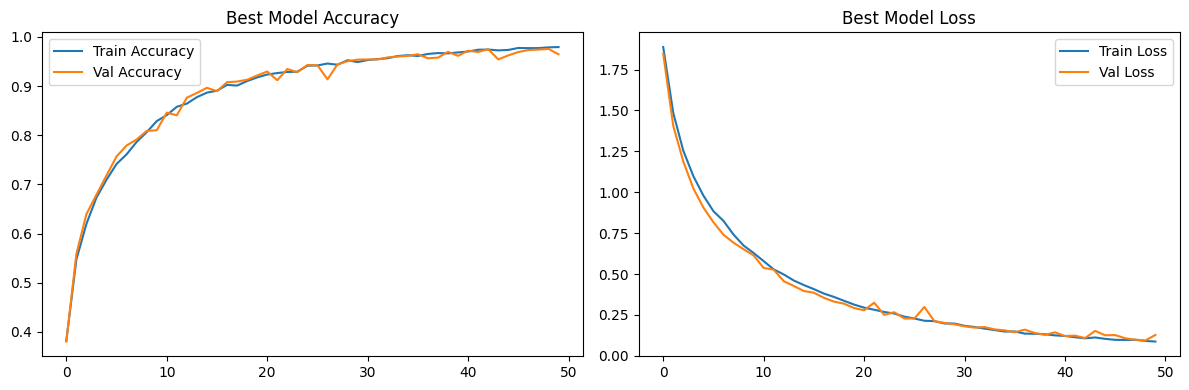

In [60]:
# Plotting Accuracy and Loss
plt.figure(figsize=(12, 4))

# Plotting Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.title("Best Model Accuracy")
plt.legend()

# Plotting Loss
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Best Model Loss")
plt.legend()

plt.tight_layout()
plt.savefig("tuned_101_model.png")
plt.show()

1/1 [==============================] - 0s 96ms/step


<Figure size 800x600 with 0 Axes>

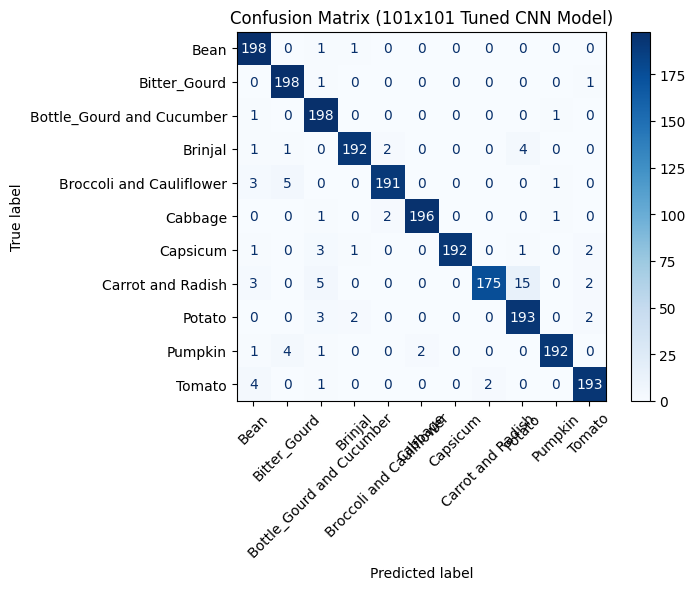

In [61]:
# Get true labels and predictions for the test set (23x23 baseline model as example)
y_true = []
y_pred = []

for images, labels in test_101:
  preds = tuned_101_model.predict(images)
  y_true.extend(labels.numpy())
  y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_ds.class_names)
plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix (101x101 Tuned CNN Model)")
plt.show()

In [62]:
# Evaluate the best model
test_loss, test_acc = tuned_101_model.evaluate(test_101)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

69/69 [==============================] - 1s 17ms/step - loss: 0.1314 - accuracy: 0.9627
Test Accuracy: 0.9627
Test Loss: 0.1314


## Compare all the models

In [63]:
# Evaluate the base CNN model's Performance
def evaluate_model_basic(model, test_ds, model_name):
    print(f"\nEvaluating {model_name}:")
    loss, accuracy = model.evaluate(test_ds, verbose=0)
    print(f"Test Loss: {loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Error Rate: {(1-accuracy):.4f}")
    return loss, accuracy

# Get metrics for comparison
loss_23, acc_23 = evaluate_model_basic(model_23, test_23, "23x23 Model")
loss_101, acc_101 = evaluate_model_basic(model_101, test_101, "101x101 Model")

print(f"\nAccuracy Improvement: {(acc_101-acc_23):.4f}")
print(f"Loss Reduction: {(loss_23-loss_101):.4f}")


Evaluating 23x23 Model:
Test Loss: 1.2164
Test Accuracy: 0.6905
Error Rate: 0.3095

Evaluating 101x101 Model:
Test Loss: 2.0630
Test Accuracy: 0.5214
Error Rate: 0.4786

Accuracy Improvement: -0.1691
Loss Reduction: -0.8466


In [64]:
# Evaluate the improved model's performance
def evaluate_model_basic_improved(model, test_ds, model_name):
    print(f"\nEvaluating {model_name} (Improved):")
    loss, accuracy = model.evaluate(test_ds, verbose=0)
    print(f"Test Loss: {loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Error Rate: {(1 - accuracy):.4f}")
    return loss, accuracy

# Evaluate improved models
loss_23_improved, acc_23_improved = evaluate_model_basic_improved(improved_model_23, test_23, "23x23 Model")
loss_101_improved, acc_101_improved = evaluate_model_basic_improved(improved_model_101, test_101, "101x101 Model")

# Comparison between improved models
print(f"\nAccuracy Improvement (101x101 - 23x23): {(acc_101_improved - acc_23_improved):.4f}")
print(f"Loss Reduction (23x23 - 101x101): {(loss_23_improved - loss_101_improved):.4f}")


Evaluating 23x23 Model (Improved):
Test Loss: 0.6790
Test Accuracy: 0.8068
Error Rate: 0.1932

Evaluating 101x101 Model (Improved):
Test Loss: 0.7790
Test Accuracy: 0.7500
Error Rate: 0.2500

Accuracy Improvement (101x101 - 23x23): -0.0568
Loss Reduction (23x23 - 101x101): -0.1000


In [65]:
# Evaluate the tuned model's performance
def evaluate_tuned_model(model, test_ds, model_name):
    print(f"\nEvaluating {model_name} (Tuned):")
    loss, accuracy = model.evaluate(test_ds, verbose=0)
    print(f"Test Loss: {loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Error Rate: {(1 - accuracy):.4f}")
    return loss, accuracy

# Evaluate tuned models
loss_23_tuned, acc_23_tuned = evaluate_tuned_model(tuned_23_model, test_23, "23x23 Model")
loss_101_tuned, acc_101_tuned = evaluate_tuned_model(tuned_101_model, test_101, "101x101 Model")

# Comparison between improved models
print(f"\nAccuracy Improvement (101x101 - 23x23): {(acc_101_improved - acc_23_improved):.4f}")
print(f"Loss Reduction (23x23 - 101x101): {(loss_23_improved - loss_101_improved):.4f}")


Evaluating 23x23 Model (Tuned):
Test Loss: 0.9486
Test Accuracy: 0.7568
Error Rate: 0.2432

Evaluating 101x101 Model (Tuned):
Test Loss: 0.1314
Test Accuracy: 0.9627
Error Rate: 0.0373

Accuracy Improvement (101x101 - 23x23): -0.0568
Loss Reduction (23x23 - 101x101): -0.1000
